# **NDWI With Dask**

This tutorial notebook demonstrates how to find, visualize, and analyze the Normalized Difference Water Index with Landsat 8 imagery, efficiently using Dask. Landsat 8 has a spatial resolution of 30 meters and temporal resolution of 16 days, which makes it ideal for medium scale imagery for water mapping. We will be focusing on the granules located near North of Vancouver Island over a eight year period.


**What is NDWI?**

The Normalized Difference Water Index (NDWI) is used for the water bodies analysis, differentiating water from dry land. Water has a low reflectance and strong absorbability in the visible infrared wavelengths range.

The index makes use of visible green light and near-infrared radiation to enhance the open water features and removing presence of soil and vegetative features. The NDWI may also estimate the turbidity of water bodies.  


**How is NDWI calculated?**

There are two way of calculating NDWI.

1. To monitor changes in the water content of water bodies, using green and near-infrared (NIR) bands.
    * **`NDWI = (Green-NIR)/(Green+NIR)`**
2. To monitor changes in the water content of leaves, using the near-infrared (NIR) and shortwave infrared (SWIR) bands. 
    * `NDWI = (NIR-SWIR)/(NIR+SWIR)`

Since we want to analyze the change in water content in the lakes located within our raster image, we will be using the **first method** with the Landsat Band 3 for Green channel and Band 5 for NIR channel. 

**What do NDWI values represent?**

Similar to the results of NDVI, the NDWI formula generates a value between -1.0 to 1.0. Water bodies NDWI value is usually greater than 0.5, while vegetation has much smaller values which makes it easy to distinguish vegetation from water bodies. Build-up features having positive values lies between 0 to 0.2.


## 1. Initialize your Dask Gateway Clusters
Since we want to use eight years of data for our analysis, running the computation using the cores of the machine we are running this notebook on is not ideal. Let's connect to Dask Gateway so we can create a cluster that can run our work.

For now, we will set our cluster to scale the workers to 30, because of the amount of data we will be working with. 

In [1]:
# First initialize the modules 
import os
import glob
import re
import datetime
import requests

import rasterio
import dask
import hvplot.xarray

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from dask_gateway import Gateway
from dask.distributed import wait, progress

In [2]:
gateway = Gateway()

# Cluster configuration 
options = gateway.cluster_options()
cluster = gateway.new_cluster(options)

In [3]:
# Scale the cluster
workers = 30
cluster.scale(workers) 

In [4]:
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client() 

In [5]:
client.wait_for_workers(workers-3)
cluster

## 2. Get the Landsat 8 Data
The Google cloud Platform provides all Landsat satellite images for public use, including all the images acquired by Landsat 8 from its launch date in 2013 till now. The **"gcp-public-data-landsat"** mount located in the GEOAnalytics folders also provide access to the Cloud Optimized GeoTIFF images. 

We will be using Collection 1 Tier 1 data which contains Landsat scenes with the highest available data quality. Tier 1 includes Level-1 Precision and Terrain (L1TP) corrected data that are radiometrically calibrated using ground control points (GCPs) and digital elevation model (DEM) data.

The function `get_landsat_data()` below retrieves and loads the location of the landsat data you want into a dataframe to be used later. 
Let's take a look at the components of this function.

1. The function takes the Landsat collection tier, WRS path, WRS Row, and the desired bands as input, to collect just that subset of data.
2. The locations of the resulting filepaths will be stored in a pandas dataframe along with their acquisition date. 
3. We will be using the *gcp-public-data-landsat* public mount to iterate through the folders for the individual filenames.
    - glob.glob() retrieves the list of paths matching the pathname.
4. Get the lists (one for each band) of files from the subfolders of the specified collection tier and the desired bands.
5. Iterate through the lists and add each image's individual bands and date as dataframe row:
    - Get the date of the current file being searched.
    - Replace the home directory path of the folder with the base domain: *'https://storage.googleapis.com/* **
    - Create a dictionary containing the acquisition date and bands
    - Append the dictionary as a row to the dataframe. 
    
** We are replacing the GEOAnalytics directory path to use the GCP URLs because our Dask Gateway clusters are being run on different machines that may not have access to the GEOAnalytics file system. To make sure our clusters can access the same data, we will use the URLs to the COG files.

In [6]:
def get_landsat_data(tier, wrs_path, wrs_row, bands_wanted):
    
    # 2. Create dataframe to store the path to the granules we want
    df = pd.DataFrame()

    # 3. Get the path of folders, and returns an iterable
    dir_path = glob.glob(f'/home/jovyan/gcp-public-data-landsat/LC08/01/0{wrs_path}/0{wrs_row}/*{tier}')

    # 4. Get list of all the files with the wanted bands
    date = 0
    for folder in dir_path:
        band0 = glob.glob(f'{folder}/*{bands_wanted[0]}.TIF')
        band1 = glob.glob(f'{folder}/*{bands_wanted[1]}.TIF')
        
        # Check if both files exist
        if not (os.path.isfile(band0[0]) or os.path.isfile(band1[0])):
            continue          
               
        ymd = '\d{4}\d{2}\d{2}' # year, month, day
        get_date = re.search(ymd, band0[0])
        new_date = datetime.datetime.strptime(get_date.group(), '%Y%m%d').date()
        if (new_date == date): 
            continue
        date = new_date
        
        #use the path to the GCP url instead of the mounted bucket
        band0[0] = band0[0].replace('/home/jovyan/','https://storage.googleapis.com/')
        band1[0] = band1[0].replace('/home/jovyan/','https://storage.googleapis.com/')
                
        file_dict = {'date':date, bands_wanted[0]:band0[0], bands_wanted[1]:band1[0]} 
        df = df.append(file_dict,ignore_index=True)
            
    return df

In [7]:
%%time
# 1. Using Landsat 8 Tier 1 data on Path 50, Row 25, and only want bands 3 and 5. 
landsat_df = get_landsat_data('T1', 50, 25, ['B3', 'B5'])
landsat_df

CPU times: user 497 ms, sys: 37.5 ms, total: 535 ms
Wall time: 6.2 s


B3  \
0    https://storage.googleapis.com/gcp-public-data...   
1    https://storage.googleapis.com/gcp-public-data...   
2    https://storage.googleapis.com/gcp-public-data...   
3    https://storage.googleapis.com/gcp-public-data...   
4    https://storage.googleapis.com/gcp-public-data...   
..                                                 ...   
115  https://storage.googleapis.com/gcp-public-data...   
116  https://storage.googleapis.com/gcp-public-data...   
117  https://storage.googleapis.com/gcp-public-data...   
118  https://storage.googleapis.com/gcp-public-data...   
119  https://storage.googleapis.com/gcp-public-data...   

                                                    B5        date  
0    https://storage.googleapis.com/gcp-public-data...  2013-06-13  
1    https://storage.googleapis.com/gcp-public-data...  2013-06-29  
2    https://storage.googleapis.com/gcp-public-data...  2013-07-15  
3    https://storage.googleapis.com/gcp-public-data...  2013-07-31  
4    https://storage.googleapis.com/gcp-public-data...  2013-09-01  
..                                                 ...         ...  
115  https://storage.googleapis.com/gcp-public-data...  2021-05-02  
116  https://storage.googleapis.com/gcp-public-data...  2021-05-18  
117  https://storage.googleapis.com/gcp-public-data...  2021-06-03  
118  https://storage.googleapis.com/gcp-public-data...  2021-07-05  
119  https://storage.googleapis.com/gcp-public-data...  2021-08-22  

[120 rows x 3 columns]

## 3. Calculating the NDWI

Now that we have all the data in the right place, let's compute the NDWI on the data! To efficiently get the NDWI for all the data, we will need a helper function to normalize our data first, similar to our method of computing NDVI.

### 3.1 Normalization Function

Normalization is a procedure of adjusting values measured on a different scale to a common scale. We will normalize the data so the computation of NDWI is done on the same scale of values. 

In [8]:
def normalize(array):
    norm = (array - array.min()) / (array.max() - array.min())
    return norm

### 3.2 Load Data Function

With the normalization function ready, we can now construct the main function for calculating the NDWI of every raster set. The function `lazy_get_data()` takes in the path of each image's individual URL for band 3 and band 5 and the Dask chunk sizes. Dask divides arrays into many small chunks that are small enough to fit into memory. Since our Geotiff images have 256 x 256 blocksize and we have over 200 files to process, let's set our chunksize to 8192 x 8192 (a larger multiple of the tile size).


The next step is to load the url into a Xarray DataArray in the assigned chunksize. The `.squeeze()` removes dimensions of length 1, and the `.drop(label='band')` removes the band from coordinates of the DataArray. 

This function is wrapped in a **Dask delayed** so that they operate lazily. It parallelizes the algorithm by placing the function and its arguments into a task graph instead of immediately executing the function.

In [9]:
@dask.delayed
def lazy_get_data(B3, B5, chunks={'band': 1, 'x': 8192, 'y': 8192}):
    # Read in the band url as an Xarray DataArray, getting rid of unneccessary dimensions
    green = xr.open_rasterio(B3, chunks=chunks).squeeze().drop(labels='band')
    nir = xr.open_rasterio(B5, chunks=chunks).squeeze().drop(labels='band')
    
    return (green, nir)

### 3.3 Calculate the NDWI of each granule

Once the DataArrays are created, we will normalize them using the helper function created above. The last step in this function is to calculate and return the NDWI using the normalized green and NIR DataArrays.

In [10]:
def get_NDWI(green, nir):
    
    #Normalize the data
    greenN = normalize(green)
    nirN = normalize(nir)
    
    # Calculate the NDWI
    ndwi = (greenN - nirN) / (greenN + nirN)
    
    return ndwi


### 3.4 Executing and storing data on the Dask Clusters

The cell below runs the functions above to get the NDWI of each row from the dataframe created in Part 2. The results from the function call are appended to a list containing the NDWI of every granule.

The most important aspect of this computation is the **`client.persist()`**. The Client.persist() executes the function call and returns a copy of each of the dask collections with the former lazy computations now submitted to run on the cluster. Here, the copy of the collection pointing to the Futures is returned immediately. When you run cell below you will see it complete execution almost instantly, but the progress bar, created by the `progress()` built-in function of "dask.distributed", shows the computation of tasks happening in the background on the dask clusters. Now, anymore queries on this persisted collection will be run very fast. 

There is *another* method called `client.compute()` which is similar to client.persist(), however this method returns only a single Future for each collection which must fit on a single worker machine. Client.compute() is ideal for smaller results that fit in memory, otherwise too large results would fail from blowing up memory space. So for our workflow, client.persist() should be used. 


In [11]:
%%time

delayed_downloads = []
for i,row in landsat_df.iterrows():
    delayed_downloads.append(lazy_get_data(row['B3'], row['B5']))
    
delayed_ndwi = []
for band in delayed_downloads:
    delayed_ndwi.append(get_NDWI(band[0], band[1]))

CPU times: user 98.5 ms, sys: 5.21 ms, total: 104 ms
Wall time: 99.6 ms


### 3.5 Combine the NDWI of all granules together in one DataArray

The next step is to concatenate the list of DataArrays from the previous step with their respective dates into a Xarray DataArray. 

In [12]:
delayed_ndwi_concat = dask.delayed(xr.concat)(delayed_ndwi, dim=pd.DatetimeIndex(landsat_df['date'], name='time'))
delayed_ndwi_concat

Delayed('concat-baf303c9-d36a-47b6-a594-bb31b7b8f292')

In [13]:
%%time
NDWI = delayed_ndwi_concat.compute().persist()
progress(NDWI)

CPU times: user 938 ms, sys: 60.8 ms, total: 998 ms
Wall time: 11.3 s


VBox()

In [14]:
print('Dataset size (Gb): ', NDWI.nbytes/1e9)
NDWI

Dataset size (Gb):  60.38127456


<xarray.DataArray (time: 120, y: 7871, x: 7991)>
dask.array<concatenate, shape=(120, 7871, 7991), dtype=float64, chunksize=(1, 7871, 7991), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 5.319e+05 5.319e+05 5.32e+05 ... 7.716e+05 7.716e+05
  * y        (y) float64 5.453e+06 5.453e+06 5.453e+06 ... 5.689e+06 5.69e+06
  * time     (time) datetime64[ns] 2013-06-13 2013-06-29 ... 2021-08-22

If you head over to the Dask Dashboard, you should notice the Datarray bytes are stored on the clusters.

## 4. Visualizing the Results

### 4.1 Plotting

To see how the NDWI changes over time, we can visualize it using HoloViz's **hvplot**.

The cell below groups the images according to time and plots the entire dataset.

In [15]:
NDWI.hvplot.image(groupby='time', x='x',y='y',
                  cmap='RdBu', clim=(-1,1), 
                  rasterize=True, dynamic=True,
                  width=700, height=500)

:DynamicMap   [time]
   :Image   [x,y]   (value)

### 4.2 Analysis

The NDWI in the region North of Vancouver Island shows change over 8 years. This change can be useful in detecting significant changes in the water bodies off the region and be used as early warning to geographic events, such as droughts, floodings, and tsunamis.   

The pattern of change occurs seasonally, as can be seen in the plot above when the water contents in the land surface is much higher in the cooler months of the year, contrasting the drier surfaces with less water bodies in the summer months. 

In [16]:
#UTM zone 18N coordinates near Regina
xcen = 734900 #712641
ycen = 5636000 #5592001
buf = 1000  # look at point +/- 1km

Text(0.5, 1.0, 'Annual change of NDWI (2020)')

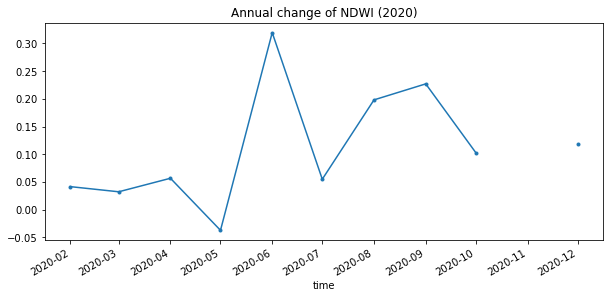

In [17]:
annual = NDWI.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen-buf,ycen+buf), time=slice('2020-01-01', '2021-01-01'))
annual_timeseries = annual.resample(time='1MS').mean().persist()

annual_timeseries.isel(x=1,y=1).plot.line(figsize=(10,4), marker='.')
plt.title("Annual change of NDWI (2020)")

Text(0.5, 1.0, 'NDVI Variation over 6 years')

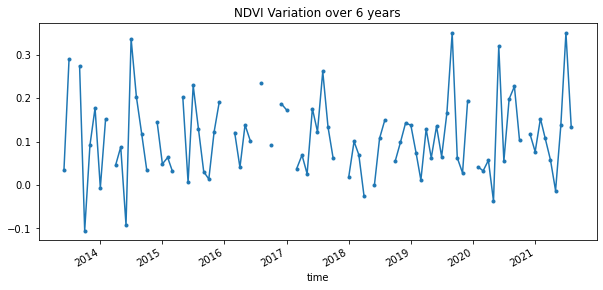

In [18]:
full_variation = NDWI.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen-buf,ycen+buf))
full_timeseries = full_variation.resample(time='1MS').mean().persist()

full_timeseries.isel(x=1,y=1).plot(figsize=(10,4), marker='.')
plt.title("NDVI Variation over 6 years")

***Make sure to always explicitly shut down computing resources when you're not using them!***

In [19]:
cluster.close()
client.close()